In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:11<00:00, 899kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 147kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.40MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.59MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 400)
        self.fc_out = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.relu(self.fc_dec(z))
        return torch.sigmoid(self.fc_out(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [4]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [5]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
model_complete_loss = VAE(latent_dim=2).to(device)
optimizer = torch.optim.Adam(model_complete_loss.parameters(), lr=1e-3)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

model_complete_loss.train()
for epoch in range(20):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model_complete_loss(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader.dataset)}")

Epoch 0, Loss: 190.77580442708333
Epoch 1, Loss: 166.84761614583334
Epoch 2, Loss: 163.8394158528646
Epoch 3, Loss: 162.24711744791668
Epoch 4, Loss: 161.07029720052083
Epoch 5, Loss: 160.01528907877605
Epoch 6, Loss: 159.06974627278646
Epoch 7, Loss: 158.15708020833333
Epoch 8, Loss: 157.3768361816406
Epoch 9, Loss: 156.61080314127605
Epoch 10, Loss: 155.85181189778646
Epoch 11, Loss: 155.1637055826823
Epoch 12, Loss: 154.5634415201823
Epoch 13, Loss: 153.98446756184896
Epoch 14, Loss: 153.460691796875
Epoch 15, Loss: 153.01595498046876
Epoch 16, Loss: 152.56344132486979
Epoch 17, Loss: 152.18061990559895
Epoch 18, Loss: 151.8027535481771
Epoch 19, Loss: 151.4634842122396


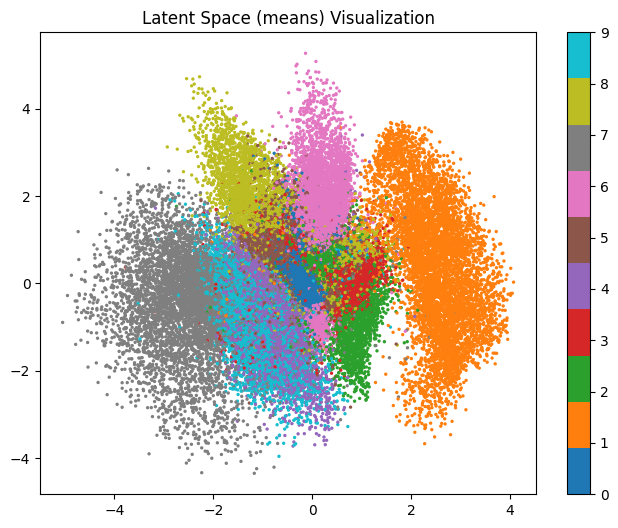

In [6]:
import matplotlib.pyplot as plt

model_complete_loss.eval()
mu_list = []
label_list = []

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        _, mu, _ = model_complete_loss(x)
        mu_list.append(mu.cpu())
        label_list.append(y)

mu_all = torch.cat(mu_list)
labels_all = torch.cat(label_list)

plt.figure(figsize=(8, 6))
plt.scatter(mu_all[:, 0], mu_all[:, 1], c=labels_all, cmap='tab10', s=2)
plt.colorbar()
plt.title("Latent Space (means) Visualization")
plt.show()

In [7]:
def loss_KL_only(recon_x, x, mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [8]:
model_KL_only = VAE(latent_dim=2).to(device)
optimizer = torch.optim.Adam(model_KL_only.parameters(), lr=1e-3)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

model_KL_only.train()
for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model_KL_only(x)
        loss = loss_KL_only(recon_x, x, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader.dataset)}")

Epoch 0, Loss: 0.0006682734886805217
Epoch 1, Loss: 1.4048971732457478e-05
Epoch 2, Loss: 4.158807297547658e-06
Epoch 3, Loss: 1.5991643071174622e-06
Epoch 4, Loss: 7.776036858558655e-07
Epoch 5, Loss: 4.410669207572937e-07
Epoch 6, Loss: 2.987295389175415e-07
Epoch 7, Loss: 2.0481646060943602e-07
Epoch 8, Loss: 2.1808197100957235e-07
Epoch 9, Loss: 2.1748393774032593e-07


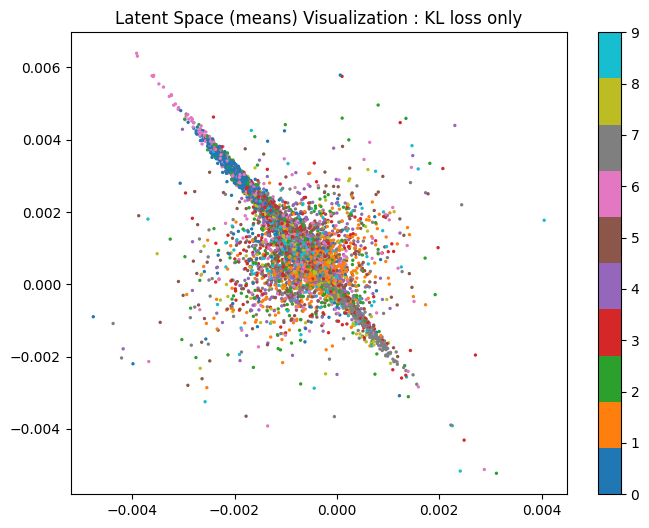

In [18]:
model_KL_only.eval()
mu_list = []
label_list = []

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        _, mu, _ = model_KL_only(x)
        mu_list.append(mu.cpu())
        label_list.append(y)

mu_all = torch.cat(mu_list)
labels_all = torch.cat(label_list)

plt.figure(figsize=(8, 6))
plt.scatter(mu_all[:, 0], mu_all[:, 1], c=labels_all, cmap='tab10', s=2)
plt.colorbar()
plt.title("Latent Space (means) Visualization : KL loss only")
plt.show()

In [10]:
def loss_recon_only(recon_x, x, mu, logvar):
    return F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')

In [11]:
from torch.utils.data import DataLoader

model_recon_only = VAE(latent_dim=2).to(device)
optimizer = torch.optim.Adam(model_recon_only.parameters(), lr=1e-3)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

model_recon_only.train()
for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model_recon_only(x)
        loss = loss_recon_only(recon_x, x, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader.dataset)}")

Epoch 0, Loss: 182.9454150390625
Epoch 1, Loss: 162.03913033854167
Epoch 2, Loss: 157.8010126953125
Epoch 3, Loss: 155.26086448567708
Epoch 4, Loss: 153.5159733561198
Epoch 5, Loss: 152.01031795247397
Epoch 6, Loss: 150.80379529622397
Epoch 7, Loss: 149.73259095052083
Epoch 8, Loss: 148.8130327311198
Epoch 9, Loss: 147.95232301432293


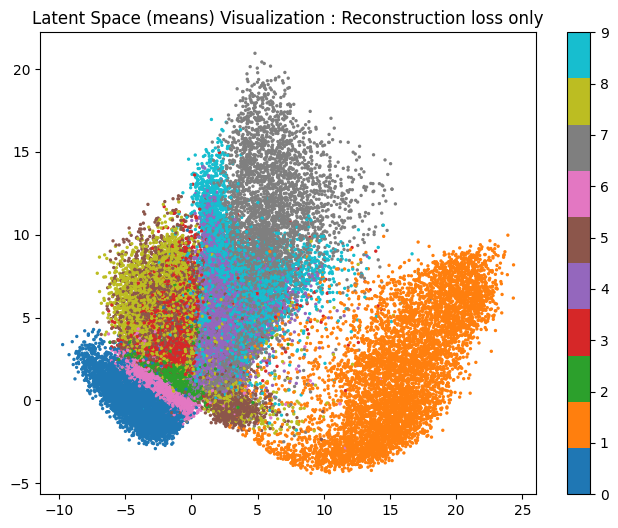

In [12]:
model_recon_only.eval()
mu_list = []
label_list = []

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        _, mu, _ = model_recon_only(x)
        mu_list.append(mu.cpu())
        label_list.append(y)

mu_all = torch.cat(mu_list)
labels_all = torch.cat(label_list)

plt.figure(figsize=(8, 6))
plt.scatter(mu_all[:, 0], mu_all[:, 1], c=labels_all, cmap='tab10', s=2)
plt.colorbar()
plt.title("Latent Space (means) Visualization : Reconstruction loss only")
plt.show()

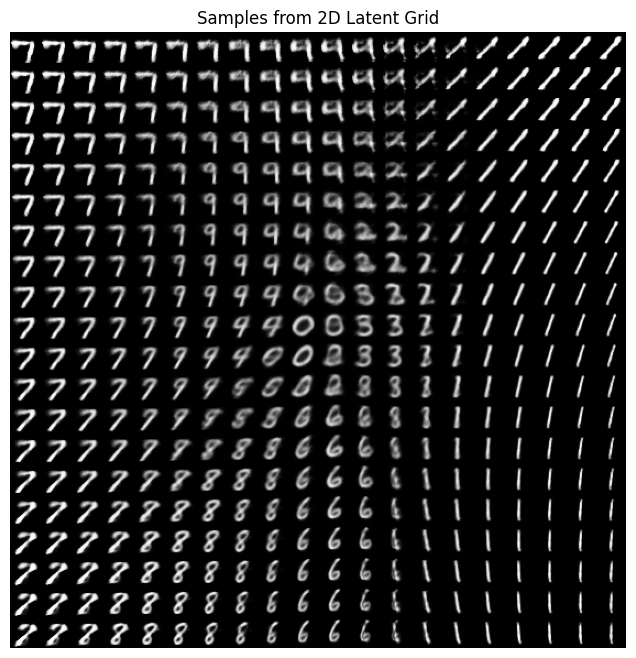

In [13]:
grid_x = torch.linspace(-4, 4, 20)
grid_y = torch.linspace(-4, 4, 20)

with torch.no_grad():
    canvas = torch.zeros(28*20, 28*20)
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            recon = model_complete_loss.decode(z).view(28, 28)
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = recon.cpu()

plt.figure(figsize=(8, 8))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.title("Samples from 2D Latent Grid")
plt.show()

In [27]:
def loss_mse(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [28]:
from torch.utils.data import DataLoader

model_mse = VAE(latent_dim=2).to(device)
optimizer = torch.optim.Adam(model_mse.parameters(), lr=1e-3)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

model_mse.train()
for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model_mse(x)
        loss = loss_mse(recon_x, x, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader.dataset)}")

Epoch 0, Loss: 49.26010655517578
Epoch 1, Loss: 42.664437475585935
Epoch 2, Loss: 41.67164753417969
Epoch 3, Loss: 41.09563627115885
Epoch 4, Loss: 40.63144863688151
Epoch 5, Loss: 40.255000569661455
Epoch 6, Loss: 39.96936773681641
Epoch 7, Loss: 39.68918895670573
Epoch 8, Loss: 39.4883975789388
Epoch 9, Loss: 39.28195115966797


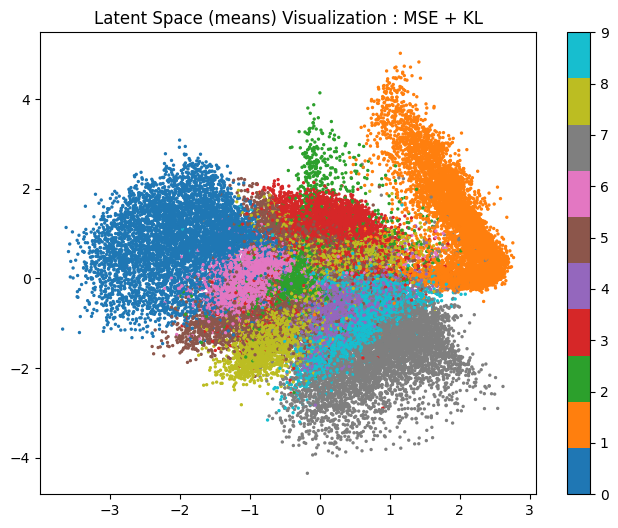

In [29]:
model_mse.eval()
mu_list = []
label_list = []

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        _, mu, _ = model_mse(x)
        mu_list.append(mu.cpu())
        label_list.append(y)

mu_all = torch.cat(mu_list)
labels_all = torch.cat(label_list)

plt.figure(figsize=(8, 6))
plt.scatter(mu_all[:, 0], mu_all[:, 1], c=labels_all, cmap='tab10', s=2)
plt.colorbar()
plt.title("Latent Space (means) Visualization : MSE + KL")
plt.show()

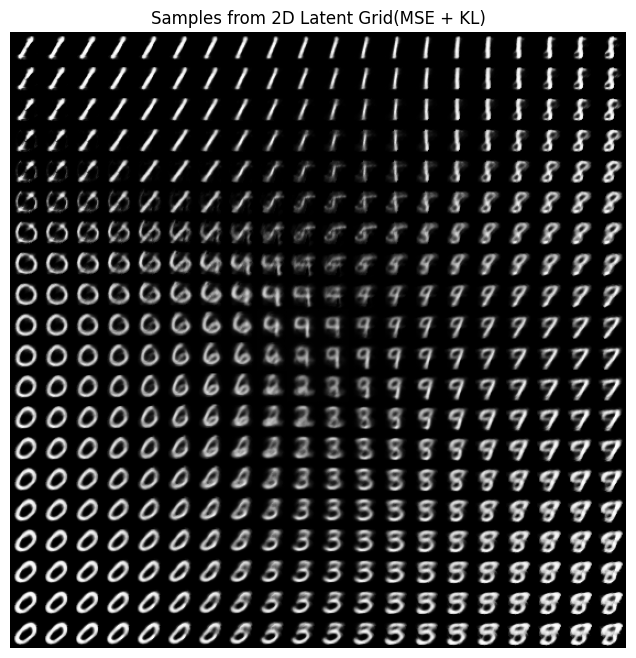

In [36]:
grid_x = torch.linspace(-3, 3, 20)
grid_y = torch.linspace(-3, 3, 20)

with torch.no_grad():
    canvas = torch.zeros(28*20, 28*20)
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            recon = model_mse.decode(z).view(28, 28)
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = recon.cpu()

plt.figure(figsize=(8, 8))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.title("Samples from 2D Latent Grid(MSE + KL)")
plt.show()

In [31]:
def loss_3mse(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return 3*MSE + KLD

In [32]:
from torch.utils.data import DataLoader

model_mse = VAE(latent_dim=2).to(device)
optimizer = torch.optim.Adam(model_mse.parameters(), lr=1e-3)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

model_mse.train()
for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model_mse(x)
        loss = loss_3mse(recon_x, x, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader.dataset)}")

Epoch 0, Loss: 141.67972485351564
Epoch 1, Loss: 120.36242503255208
Epoch 2, Loss: 116.62105200195313
Epoch 3, Loss: 114.36762983398438
Epoch 4, Loss: 112.68217755533854
Epoch 5, Loss: 111.40397348632813
Epoch 6, Loss: 110.40127366536458
Epoch 7, Loss: 109.53748375651041
Epoch 8, Loss: 108.81810960286458
Epoch 9, Loss: 108.16916162109375


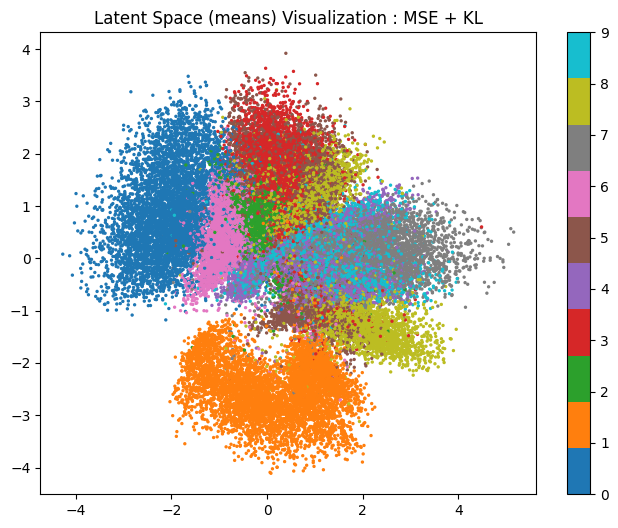

In [33]:
model_mse.eval()
mu_list = []
label_list = []

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        _, mu, _ = model_mse(x)
        mu_list.append(mu.cpu())
        label_list.append(y)

mu_all = torch.cat(mu_list)
labels_all = torch.cat(label_list)

plt.figure(figsize=(8, 6))
plt.scatter(mu_all[:, 0], mu_all[:, 1], c=labels_all, cmap='tab10', s=2)
plt.colorbar()
plt.title("Latent Space (means) Visualization : MSE + KL")
plt.show()

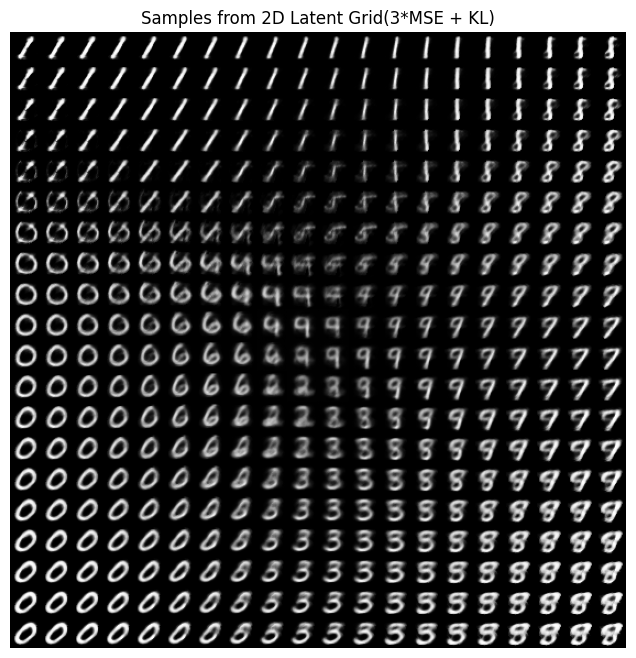

In [37]:
grid_x = torch.linspace(-3, 3, 20)
grid_y = torch.linspace(-3, 3, 20)

with torch.no_grad():
    canvas = torch.zeros(28*20, 28*20)
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            recon = model_mse.decode(z).view(28, 28)
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = recon.cpu()

plt.figure(figsize=(8, 8))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.title("Samples from 2D Latent Grid(3*MSE + KL)")
plt.show()